In [1]:
import torch
from edm.edm import EDM
import tqdm
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
import edm.modules as modules
from data import SequencesDataset
from train import train
import torchvision.transforms as transforms
import os
import numpy as np
import matplotlib.pyplot as plt
from typing import List

In [2]:
EPOCHS = 30

input_channels = 3
context_length = 4
actions_count = 5
batch_size = 4
num_workers = 2
device = "cuda" if torch.cuda.is_available() else "cpu"
# For Mac OS
if torch.backends.mps.is_available():
    device = "mps"

ROOT_PATH = "../"
# ROOT_PATH = "./"
def local_path(path):
    return os.path.join(ROOT_PATH, path)

In [3]:
ddpm = EDM(
    p_mean=-1.2,
    p_std=1.2,
    sigma_data=0.5,
    model=modules.UNet((input_channels) * (context_length + 1), 3, None, actions_count, context_length),
    context_length=context_length,
    device=device
)

In [4]:
transform_to_tensor = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((.5,.5,.5), (.5,.5,.5))
])

dataset = SequencesDataset(
    images_dir=local_path("training_data/snapshots"),
    actions_path=local_path("training_data/actions"),
    seq_length=context_length,
    transform=transform_to_tensor
)

total_size = len(dataset)
train_size = int(0.8 * total_size)  # 80% for training
valid_size = total_size - train_size  # 20% for validation

# Split the dataset
train_dataset, val_dataset = random_split(
    dataset, 
    [train_size, valid_size]
)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

In [8]:
def save_imgs(
    frames_real: torch.Tensor,
    frames_gen: List[torch.Tensor],
    path: str
):
    def get_np_img(tensor: torch.Tensor) -> np.ndarray:
        return (tensor * 127.5 + 127.5).long().clip(0,255).permute(1,2,0).detach().cpu().numpy().astype(np.uint8)

    height_row = 5
    col_width = 5
    cols = len(frames_real)
    rows = 1 + len(frames_gen)
    fig, axes = plt.subplots(rows, cols, figsize=(col_width * cols, height_row * rows))
    for row in range(rows):
        frames = frames_real if row == 0 else frames_gen[row - 1]
        for i in range(len(frames_real)):
            axes[row, i].imshow(get_np_img(frames[i]))
            
    plt.subplots_adjust(wspace=0, hspace=0)
    
    # Save the combined figure
    plt.savefig(path, bbox_inches='tight', pad_inches=0)
    plt.close()

/var/folders/86/y0z0q3m90ydfj3zjqshtv84r0000gp/T/ipykernel_56576/2170600945.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  parameters = torch.load(local_path("test_mod

FileNotFoundError: [Errno 2] No such file or directory: '/Users/moshkov/Projects/ai-projects/snake-diffusion/diffusion/val_images/1.png'

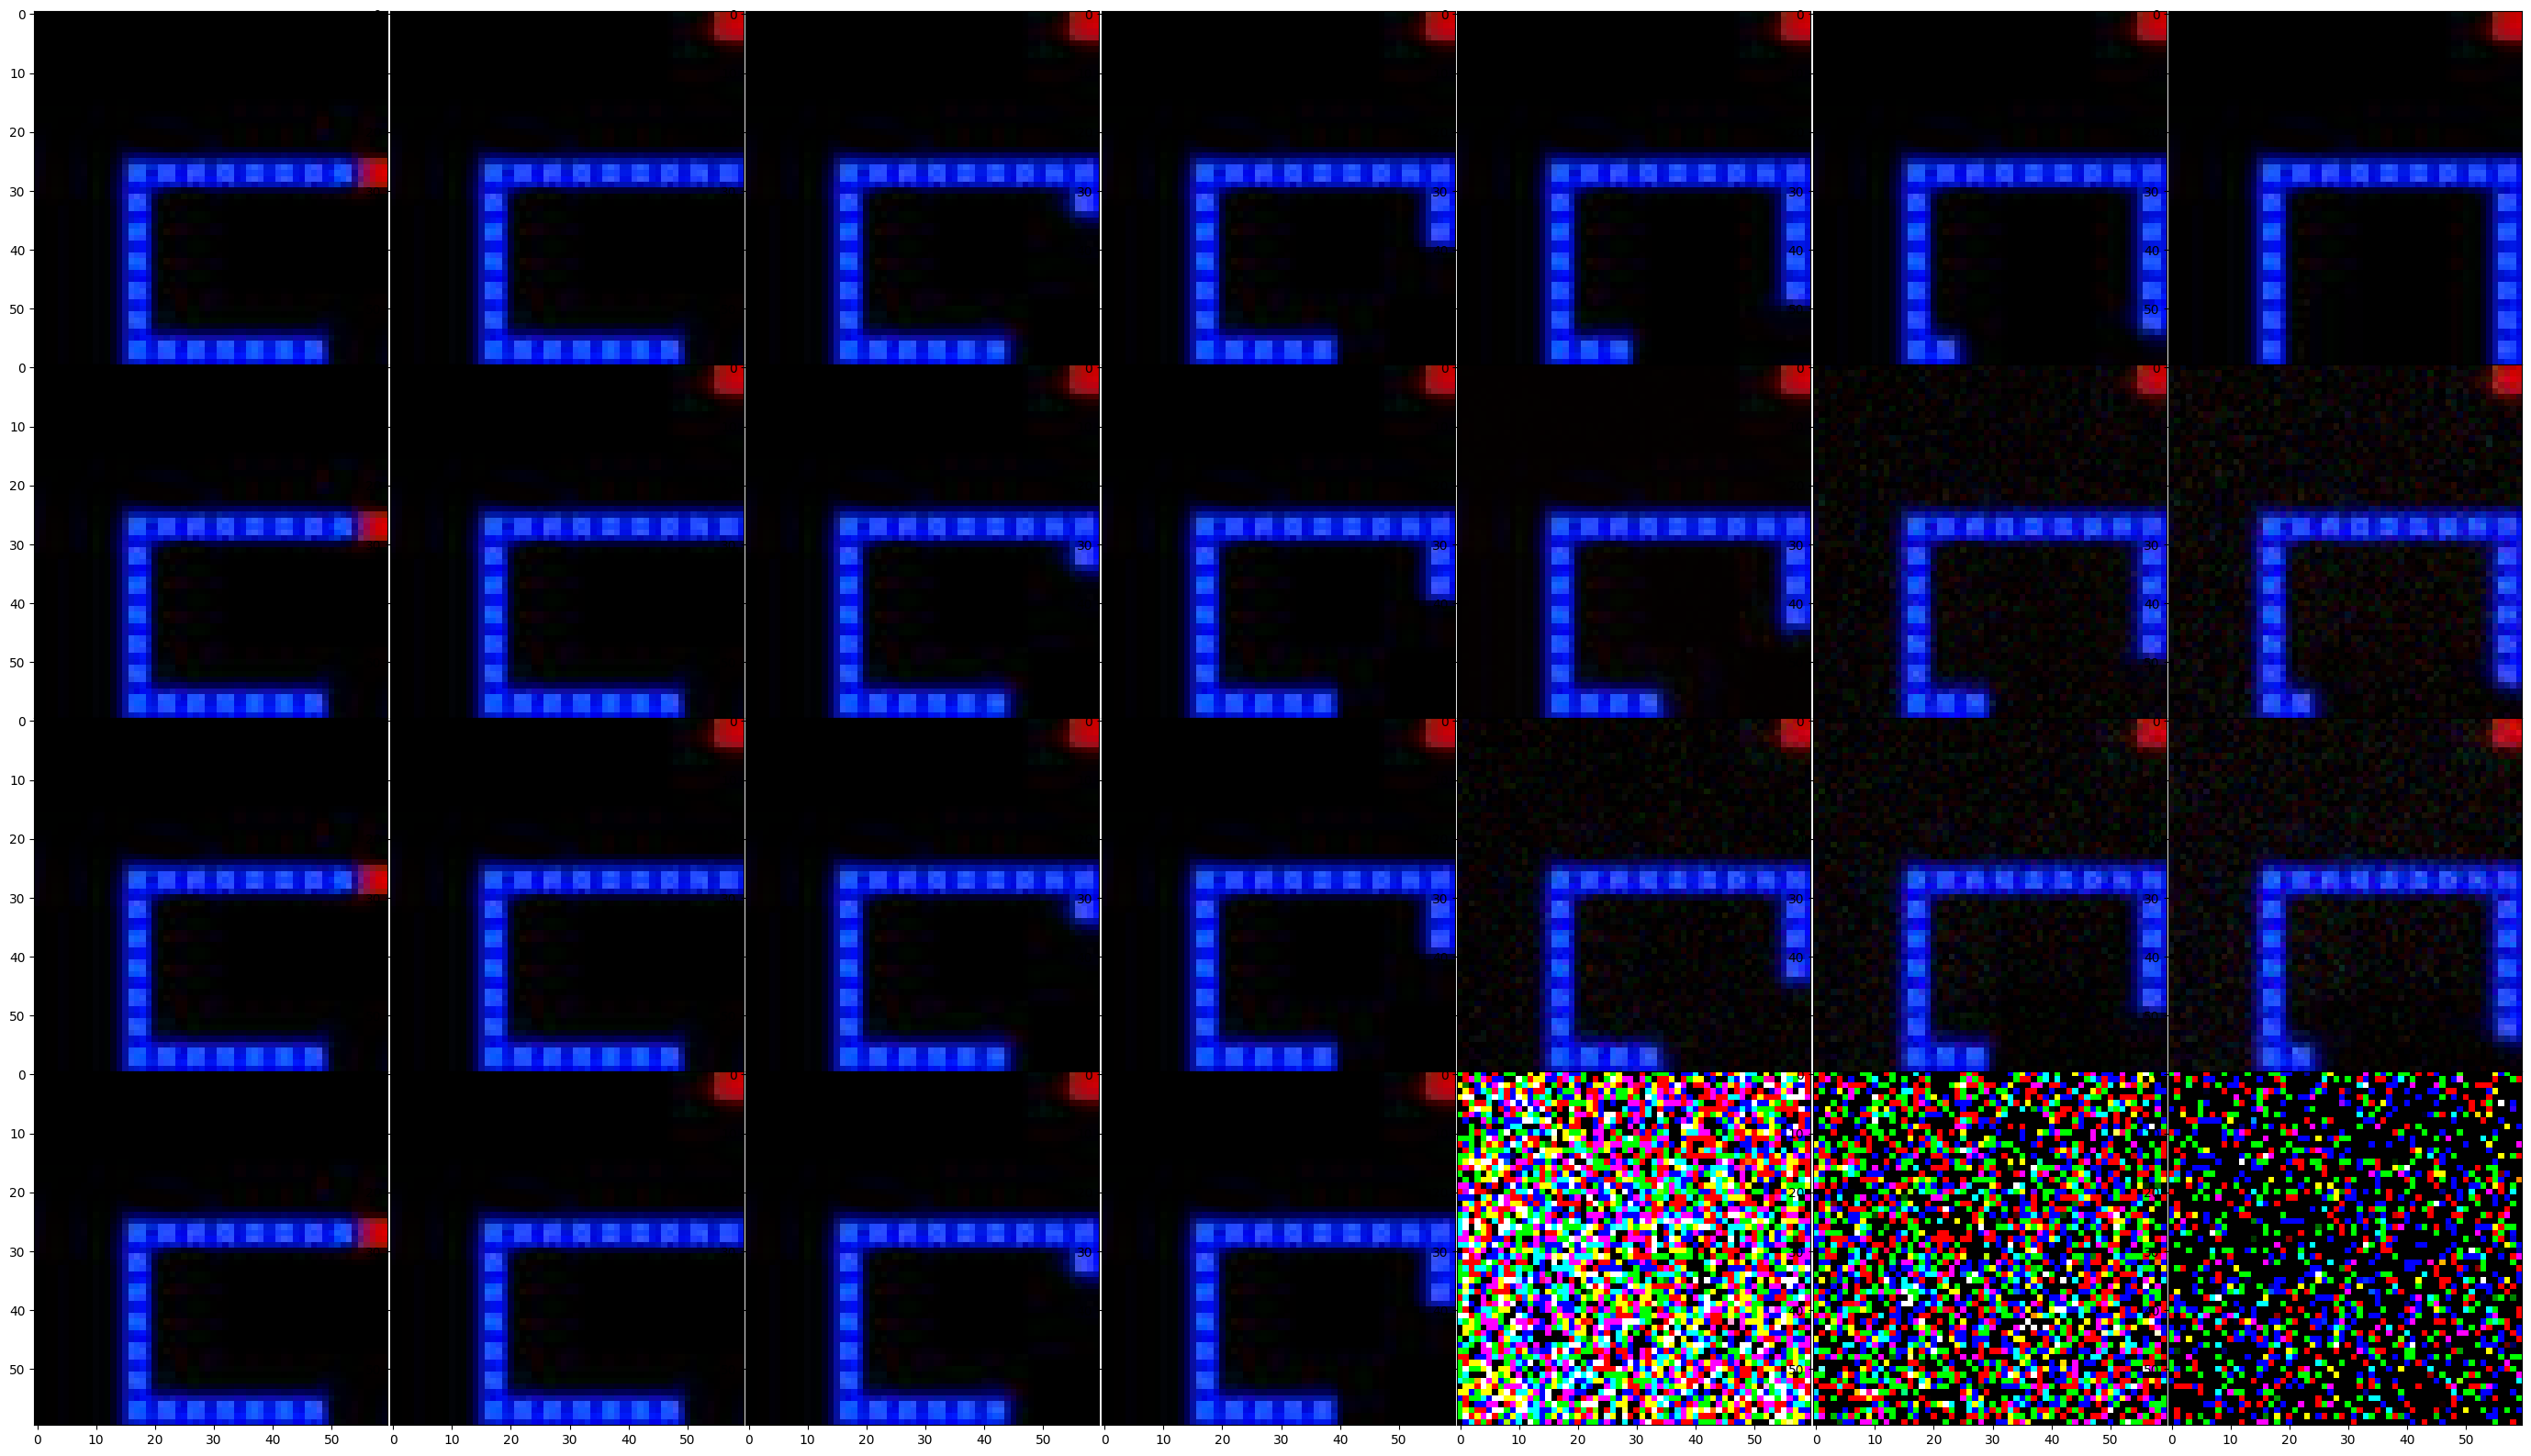

In [9]:
import random
def generate_imgs(
    model: EDM,
    previous_frames: torch.Tensor,
    previous_actions: torch.Tensor,
    real_imgs: torch.Tensor,
    epoch: int,
    length_session = 60
):
    index = random.randint(0, len(dataset) - 1 - length_session)

    img, last_imgs, actions = dataset[index]

    img = img.to(device)
    last_imgs = last_imgs.to(device)
    actions = actions.to(device)

    real_imgs = last_imgs.clone()
    gen_2_imgs = last_imgs.clone()
    gen_10_imgs = last_imgs.clone()
    gen_5_imgs = last_imgs.clone()
    for j in range(1, length_session):
        img, last_imgs, actions = dataset[index + j]
        img = img.to(device)
        last_imgs = last_imgs.to(device)
        actions = actions.to(device)
        real_imgs = torch.concat([real_imgs, img[None, :, :, :]], dim=0)
        gen_img = model.sample(img.shape, gen_10_imgs[-context_length:].unsqueeze(0), actions.unsqueeze(0), num_steps=10)[0][:, 2:-2, 2:-2]
        gen_10_imgs = torch.concat([gen_10_imgs, gen_img[None, :, :, :]], dim=0)
        gen_img = model.sample(img.shape, gen_2_imgs[-context_length:].unsqueeze(0), actions.unsqueeze(0), num_steps=2)[0][:, 2:-2, 2:-2]
        gen_2_imgs = torch.concat([gen_2_imgs, gen_img[None, :, :, :]], dim=0)
        gen_img = model.sample(img.shape, gen_5_imgs[-context_length:].unsqueeze(0), actions.unsqueeze(0), num_steps=10)[0][:, 2:-2, 2:-2]
        gen_5_imgs = torch.concat([gen_5_imgs, gen_img[None, :, :, :]], dim=0)

    save_imgs(real_imgs, [gen_10_imgs, gen_5_imgs, gen_2_imgs], f"val_images/{epoch}.png")

# parameters = torch.load(local_path("test_models/diffusion/model_19_edm.pth"), map_location=device)
# ddpm.load_state_dict(parameters["model"])
# generate_imgs(ddpm, torch.tensor([]), torch.tensor([]), torch.tensor([]), 1, 4)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/moshkov/Projects/ai-projects/snake-diffusion/diffusion/val_images/1_10.png'

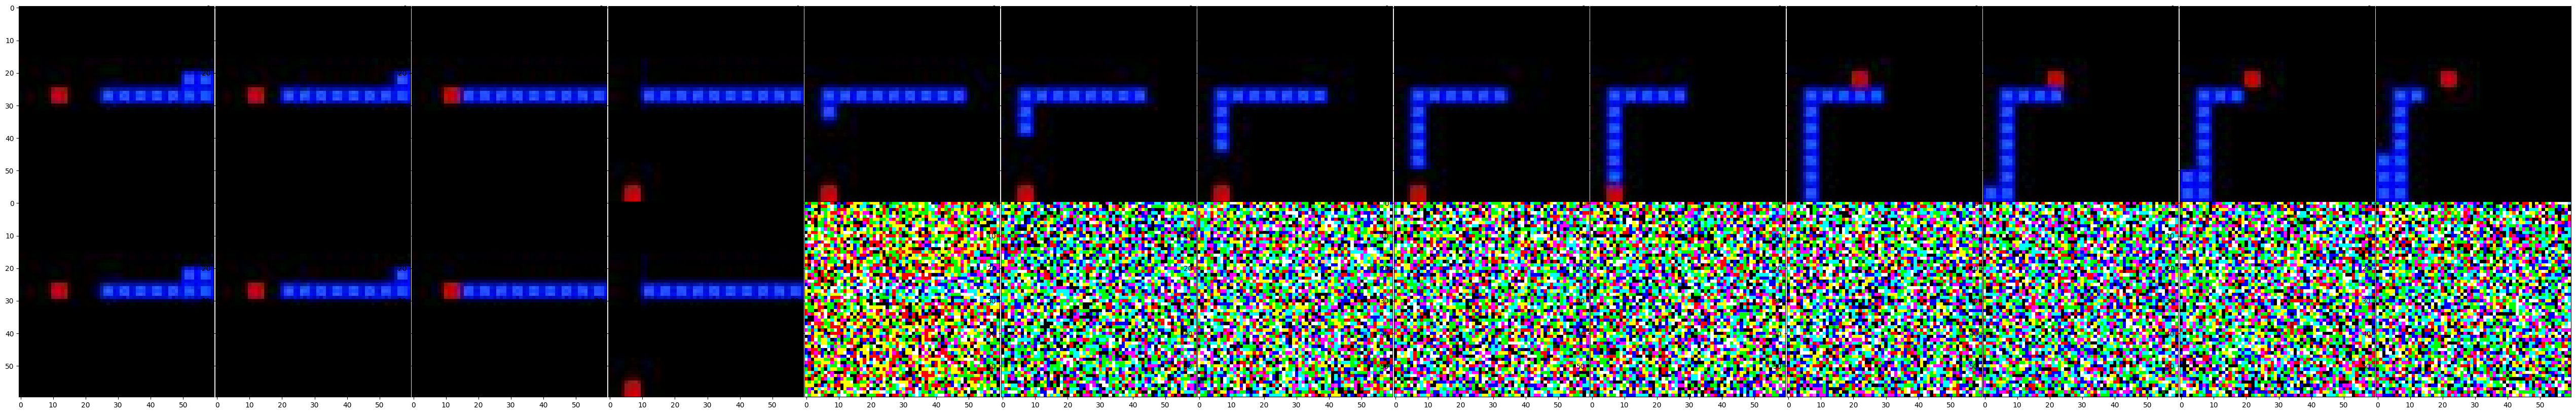

In [9]:
_, val_losses = train(
    model=ddpm,
    epochs=EPOCHS,
    device=device,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    save_every_epoch=1,
    existing_model_path=local_path("model_12_edm.pth"),
    save_imgs=generate_imgs
)